In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d
from scipy.optimize import curve_fit

C:\Users\andr\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [422]:
@np.vectorize
def real_num(s, prev=None, allow_pow=True):
    if '?' in s or len(s) > 4:
        return float('NaN')
    if len(s) == 4:
        if allow_pow:
            if s[-1] == '1':
                return real_num(s[:-1], allow_pow=False)/10**3
            elif s[-1] == '2':
                return real_num(s[:-1], allow_pow=False)/10**4
            elif s[-1] == '3':
                return real_num(s[:-1], allow_pow=False)/10**5
        if s == '1000':
            return 1000.0
        else:
            return float('NaN')
    
    return float(s)

def second_filter(x, y):
    for i in range(1, len(x) - 1):
        if abs(y[i] - y[i - 1]) > 50 and abs(y[i] - y[i + 1]) > 50 and (y[i] - y[i + 1]) * (y[i] - y[i - 1]) > 0:
            y[i] = float('NaN')
            #print("!")
        #if abs(y[i] - y[i - 1]) != 0.0: print(abs(y[i] - y[i - 1]), abs(y[i] - y[i + 1]), (y[i] - y[i + 1]) * (y[i] - y[i - 1]))
    mask = y == y
    return x[mask], y[mask]

def order_swap(t, y, order):
    curr_order = 0
    keys = list(sorted(order.keys()))
    ind = 0
    for i in range(len(y)):
        if len(keys) > ind + 1 and t[i] > keys[ind + 1]:
            ind += 1
            
        y[i] *= 10**order[keys[ind]]
    return y

def plot_measure(name, order = None, log=True):
    d = pd.read_csv(f"data/{name}.csv", delimiter=";", comment = "#", header=None)
    data = np.array([d[0], d[1]])

    def filter_bad(time, p):
        p = real_num(p)

        mask = p == p
        return time[mask], p[mask]
    
    

    x, y = filter_bad(data[0], data[1])
    if order is not None:
        y = order_swap(x, y, order)
    x, y = np.array(x, dtype=float), np.array(y, dtype=float)
    x, y = second_filter(x, y)
    
    y = uniform_filter1d(y, 4)
    
    
    def approx_event(e):
        try:
            x_ind = (np.abs(x - e.xdata)).argmin()
            # plt.gca().set_title(f'x={x_ind}, y={e.xdata}, {approx_event.first_set}')


            if approx_event.first_set:
                if x_ind != approx_event.first_set:
                    if e.button == 1:
                        line_approx(*sorted([approx_event.first_x, x_ind]))
                    elif e.button == 3:
                        exp_approx(*sorted([approx_event.first_x, x_ind]))
            else:
                approx_event.first_x = x_ind

            approx_event.first_set = not approx_event.first_set
            
        except Exception as e:
            plt.gca().set_title(f'Error: {e}')
    
    approx_event.first_set = False
    approx_event.first_x = None
        
    def exp_approx(t1, t2):
        def f(x, A, B, C):
            return np.log(C*np.exp(A*x) + B)
        
        res, err = curve_fit(f, x[t1:t2+1], np.log(y[t1:t2+1]), p0=[-0.01, (y[t1] + y[t2])/2, np.sign(y[t1] - y[t2])],
                            bounds = ((-0.5, -np.inf, -100), (5, np.inf, 100)))
        # plt.gca().set_title(f'{res}')
        plt.plot(x[t1:t2], np.exp(f(x[t1:t2], *res)), '--', linewidth=3, label=f'{round(res[2],4)} · exp({round(res[0],4)} · t) {"{:+.4}".format(res[0])}')
        plt.legend(prop={'size': 8})
    
    def line_approx(t1, t2):
        def f(x, B, C):
            return B + C*x
        
        res, err = curve_fit(f, x[t1:t2+1], np.log(y[t1:t2+1]), p0=[(y[t1] + y[t2])/2, (y[t2] - y[t1])/(x[t2] - x[t1])],
                            bounds = ((-np.inf,-1e6), (np.inf,1e6)))
        # plt.gca().set_title(f'{res}')
        plt.plot(x[t1:t2], np.exp(f(x[t1:t2], *res)), '--', linewidth=3, label=f'{"{:.4}".format(np.exp(res[0]))} · exp({round(res[1],4)}·t )')
        plt.legend(prop={'size': 8})
    
    fig = plt.figure(figsize=(10,7))
    
    if log: plt.yscale('symlog')
    #plt.loglog()
    n_y = uniform_filter1d(uniform_filter1d(uniform_filter1d(uniform_filter1d(np.diff(uniform_filter1d(y, 10))/np.diff(x), 20), 20), 20), 30)
    plt.plot(x[1:], n_y)
    plt.plot(x[1:], np.zeros(len(x[1:])), ":")
    plt.savefig(f"img/{name}_speed.jpeg")
    
    plt.gca().set_ylim([-10*abs(np.median(n_y)), 10*abs(np.median(n_y))])
    
    plt.yticks(np.concatenate((np.linspace(-10*abs(np.median(n_y)), 0, 5), np.linspace(0, 10*abs(np.median(n_y)), 5))))
    plt.savefig(f"img/{name}_speed_small.jpeg")
    
    fig = plt.figure(figsize=(10,7))
    fig.canvas.mpl_connect('button_press_event', approx_event)
    if log: plt.yscale('log')
    plt.plot(x,y)
    plt.savefig(f"img/{name}.jpeg")
    
    
    #plt.plot(x[0:100], f(x[0:100], *res))
    #approx(0, 100)

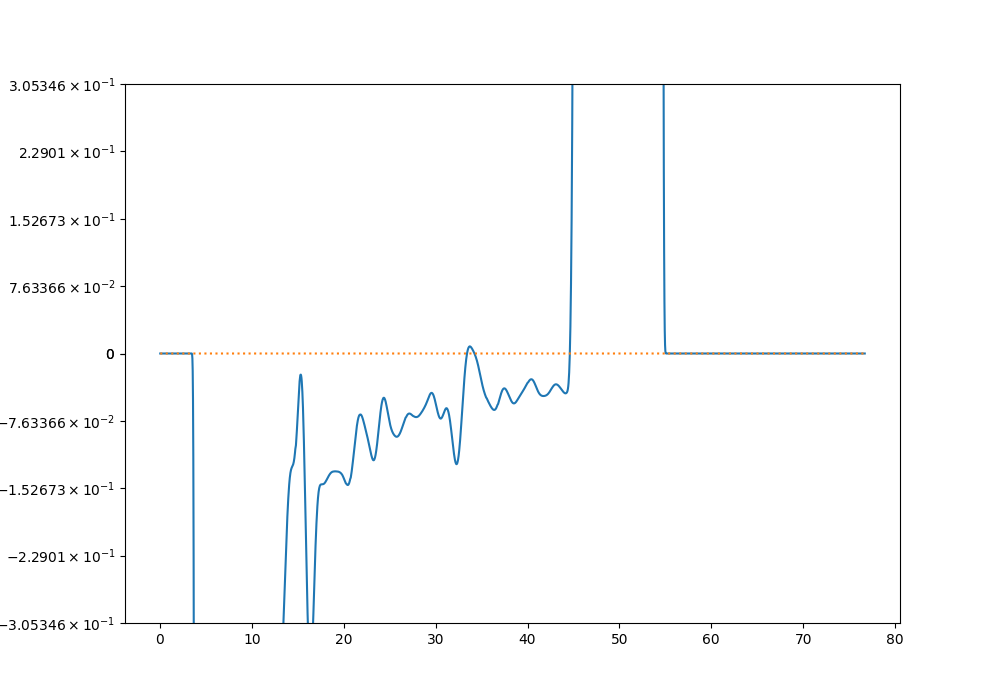

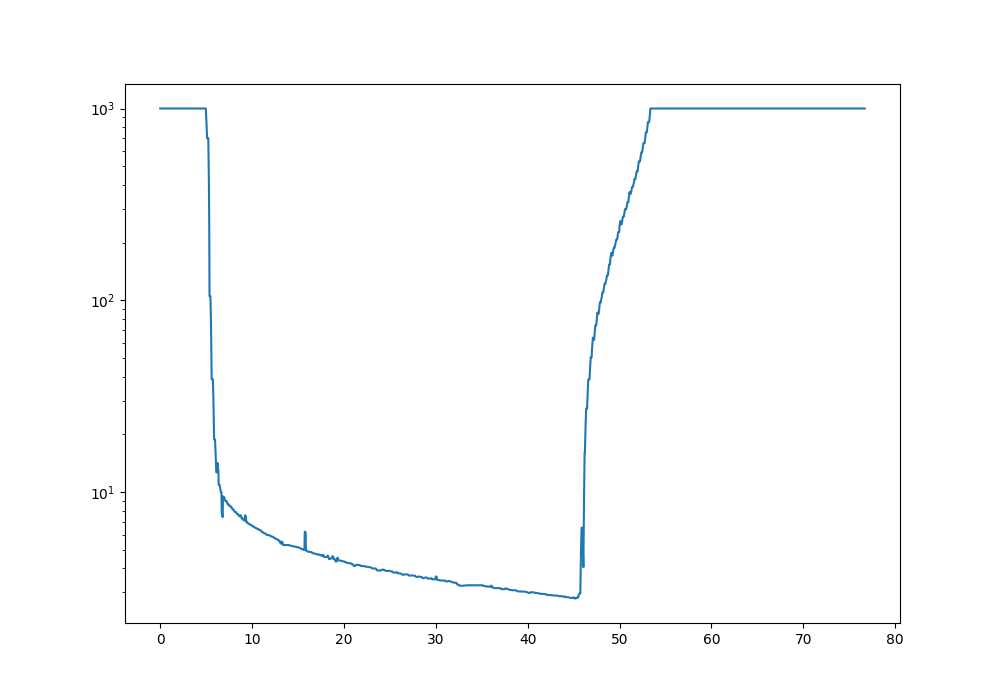

In [423]:
%matplotlib widget
x = plot_measure('IMG_5567', {0: 0, 5.5: -1, 6.7: -2, 46.1: -1, 48.0: 0})

In [424]:
plt.gca().set_title("")

Text(0.5, 1.0, '')

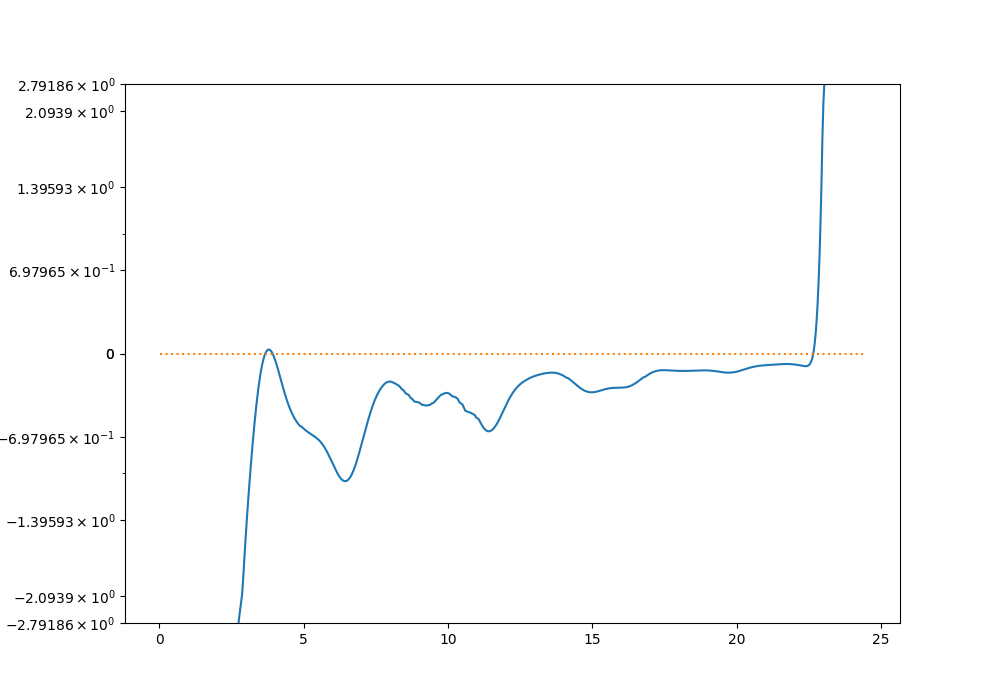

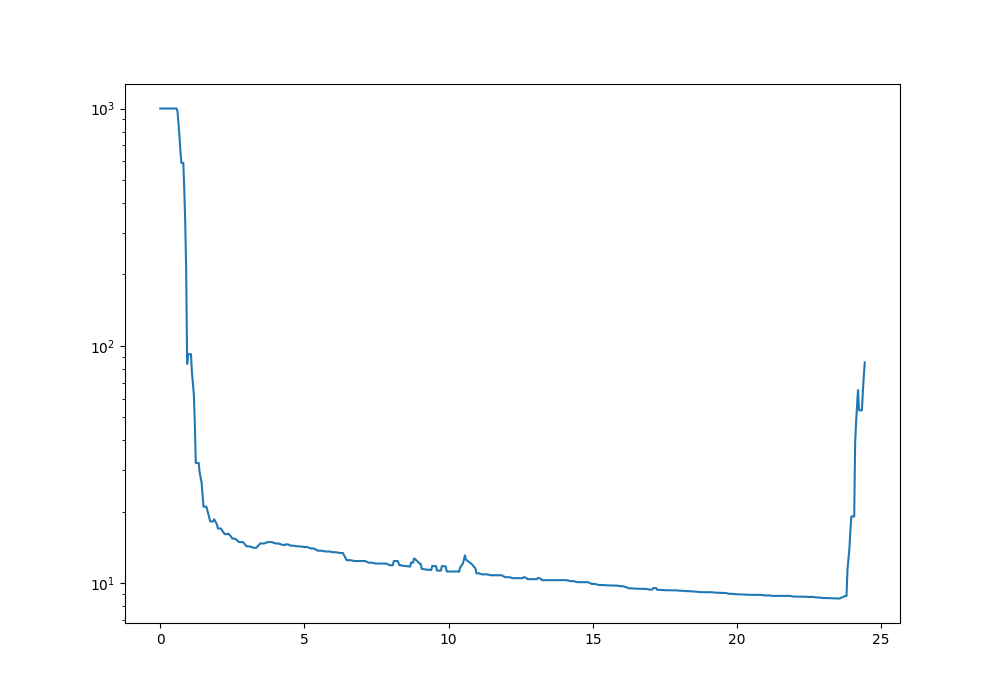

In [425]:
%matplotlib widget
plot_measure('IMG_5568', {0:0, 0.86:-1, 14.87: -2, 23.85: -1})

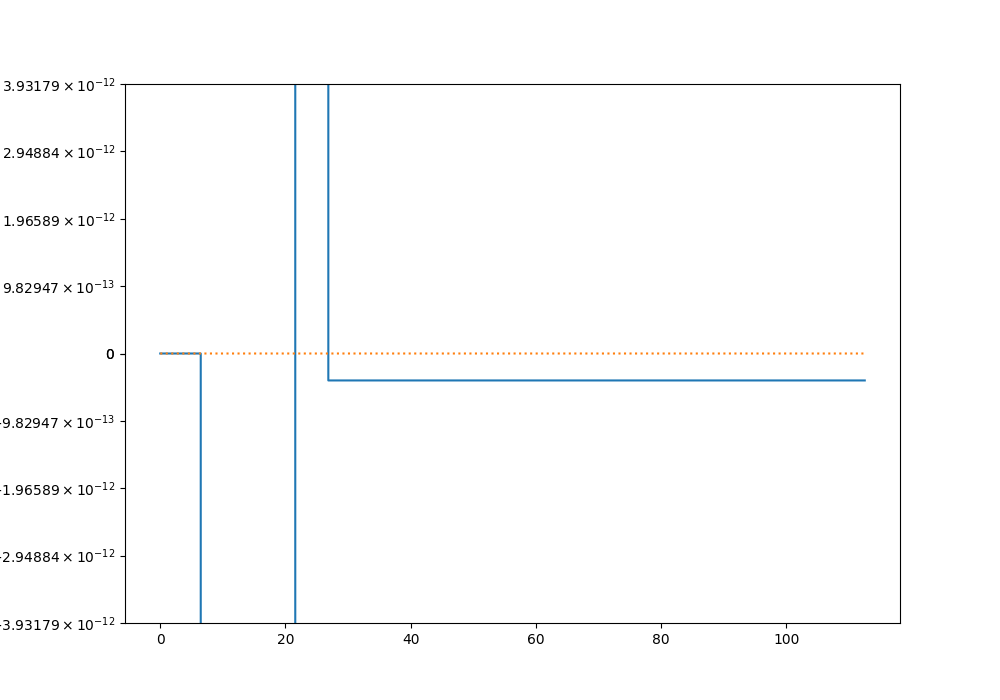

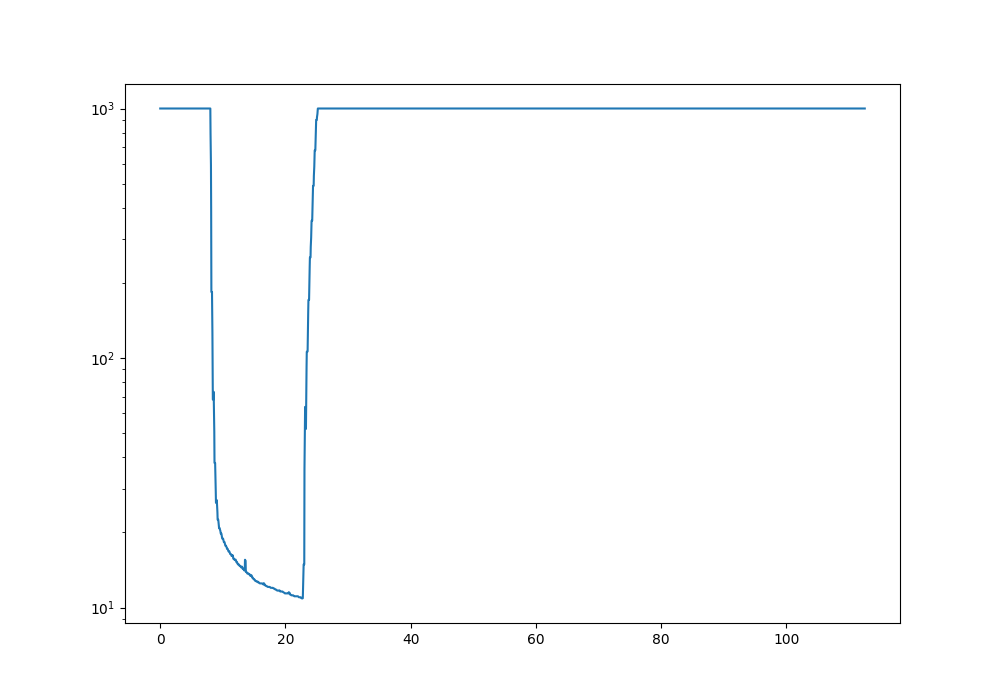

In [426]:
%matplotlib widget
plot_measure('IMG_5569', {0:0, 8.3: -1, 23.3: 0})

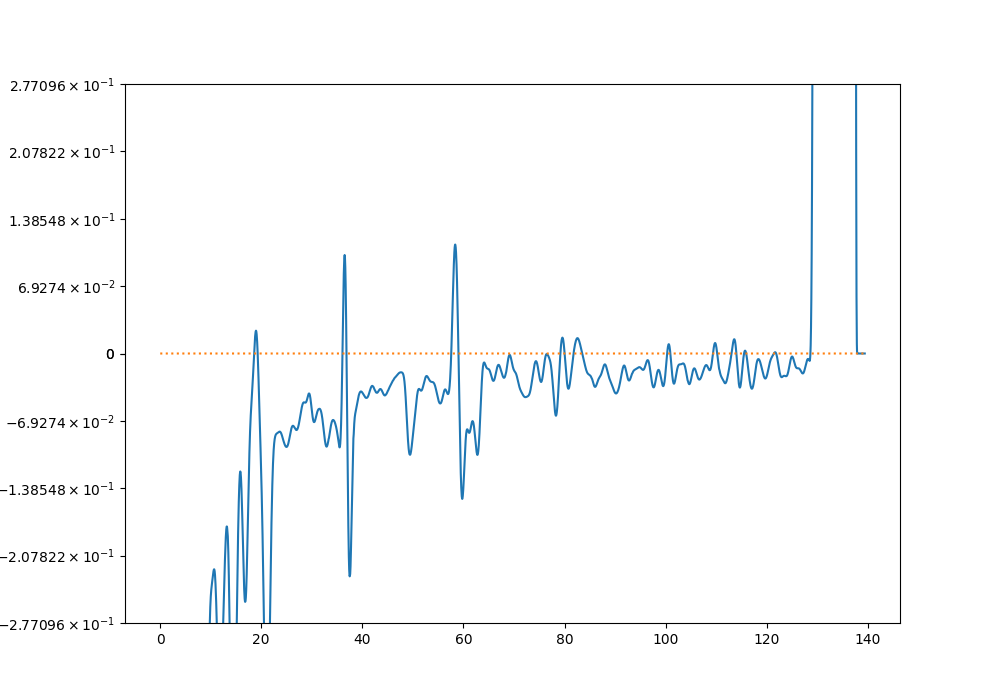

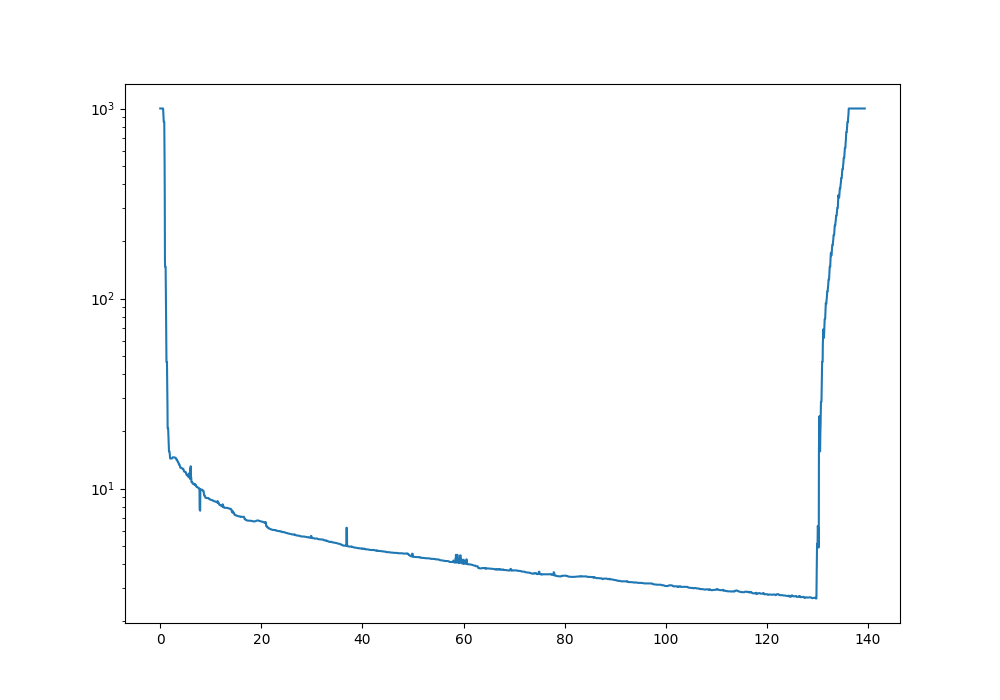

In [427]:
%matplotlib widget
plot_measure('IMG_5570', {0:0, 1.1: -1, 7.81: -2.0, 130.3: -1, 131.8: 0})

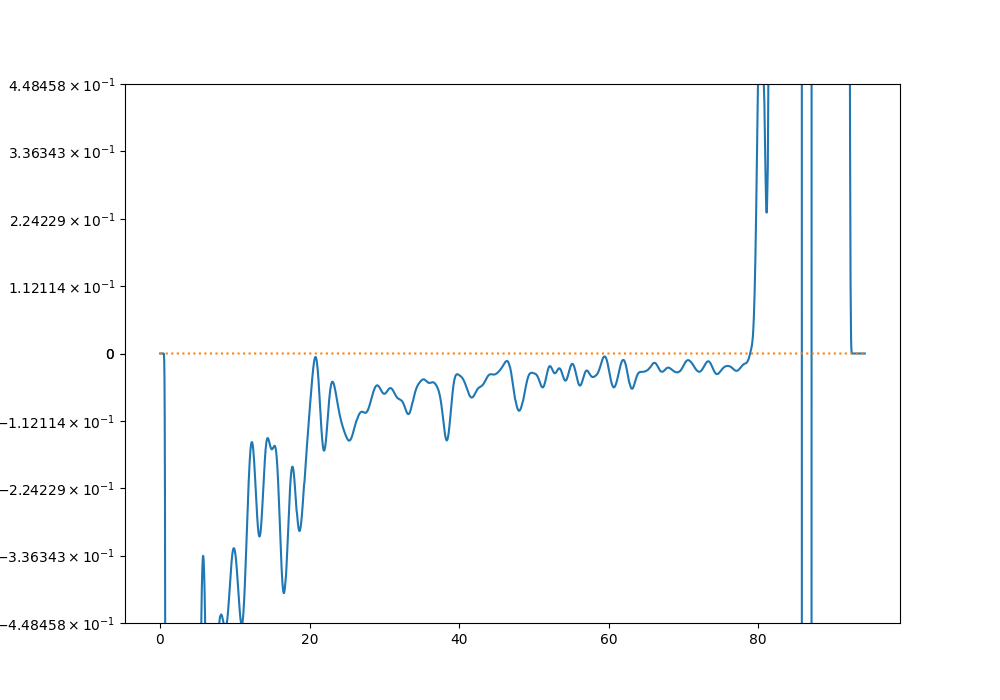

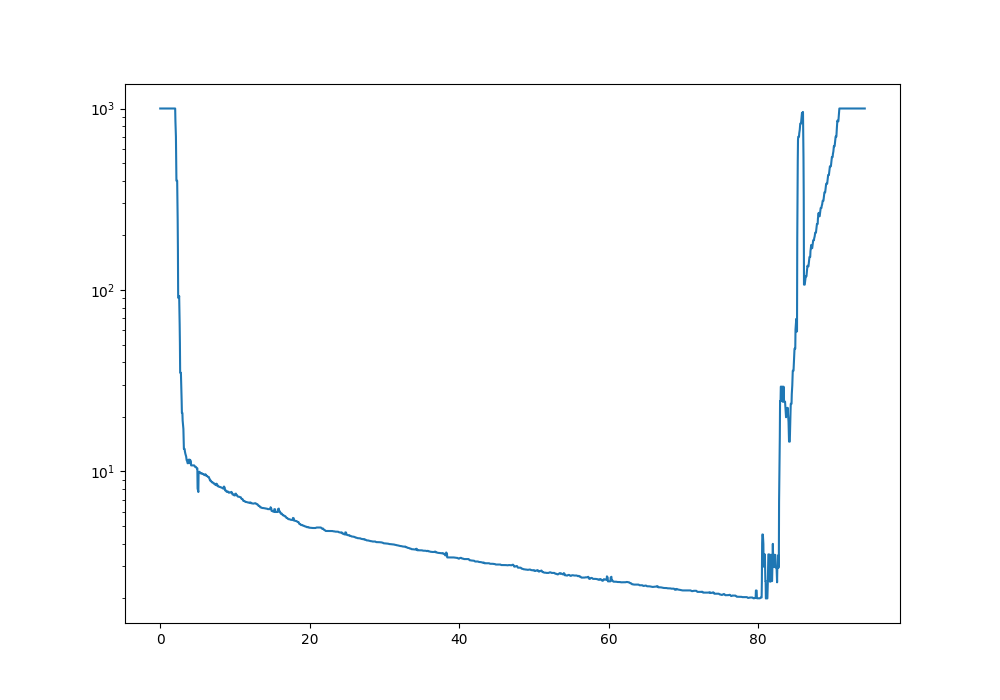

In [428]:
%matplotlib widget
plot_measure('build_2', {0:0, 2.3: -1, 5.0: -2, 82.8: -1, 85.25: 0})

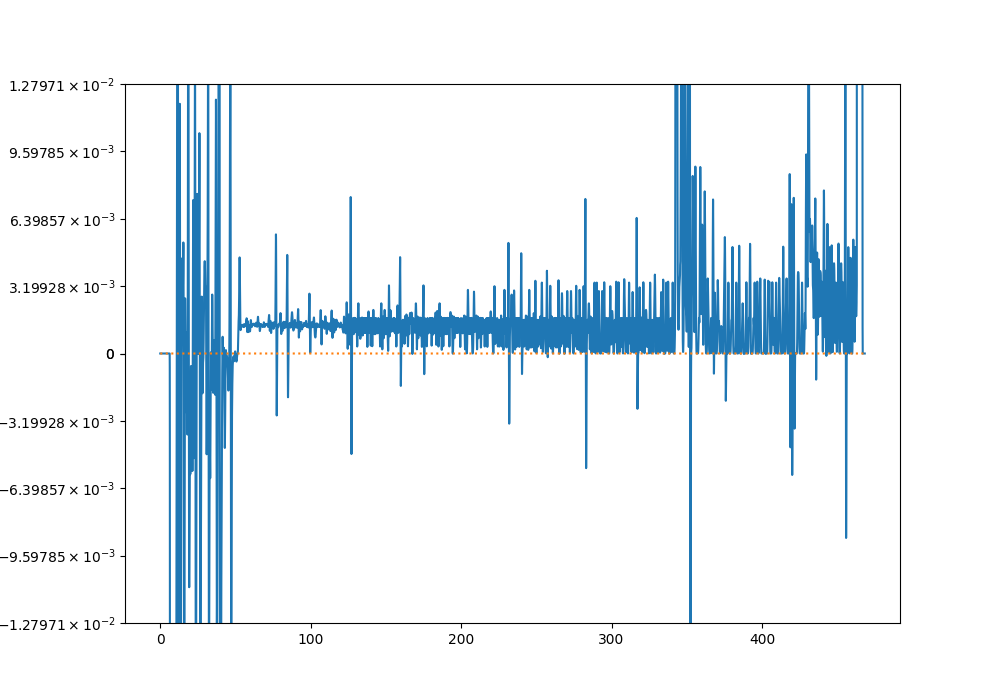

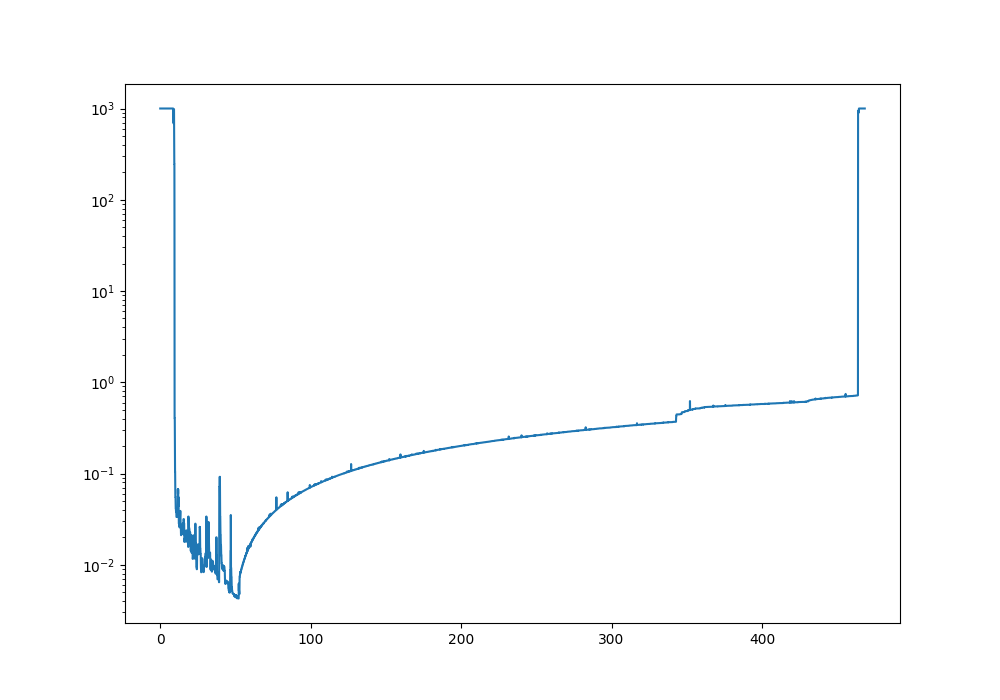

In [436]:
%matplotlib widget
plot_measure('nothing') #, {0:0, 9.4: -4, 10.5: -6, 54.68: -5, 463:0}

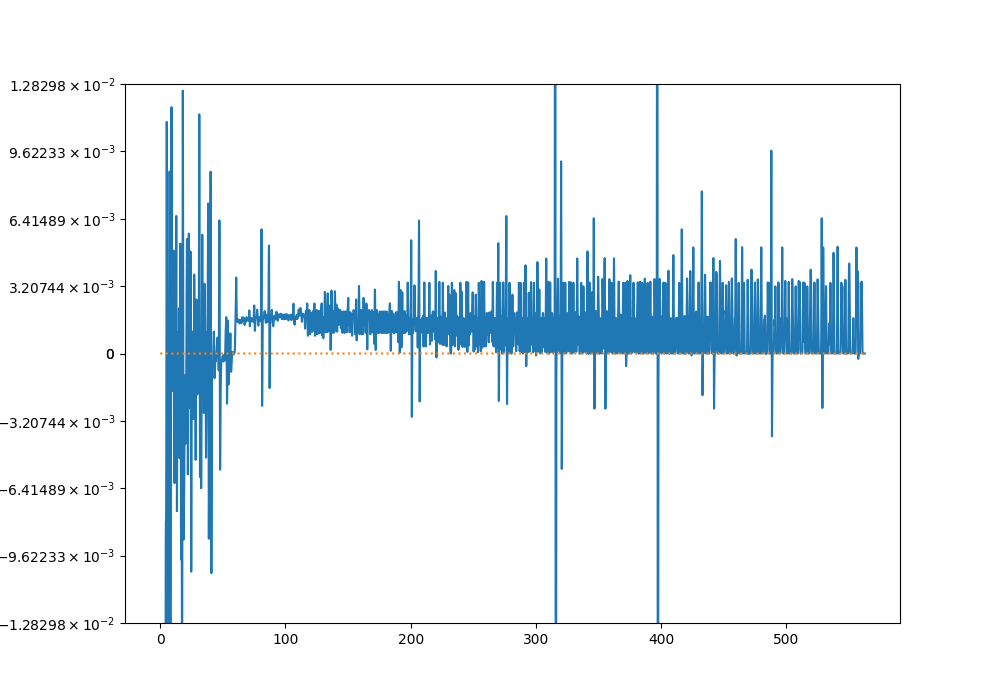

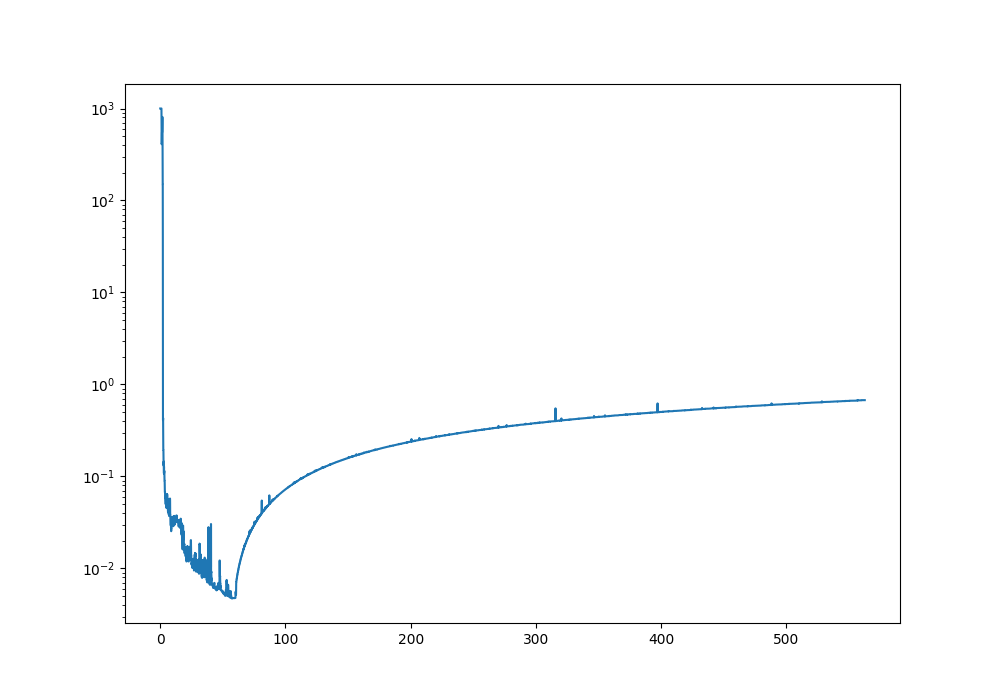

In [437]:
%matplotlib widget
plot_measure('simple')

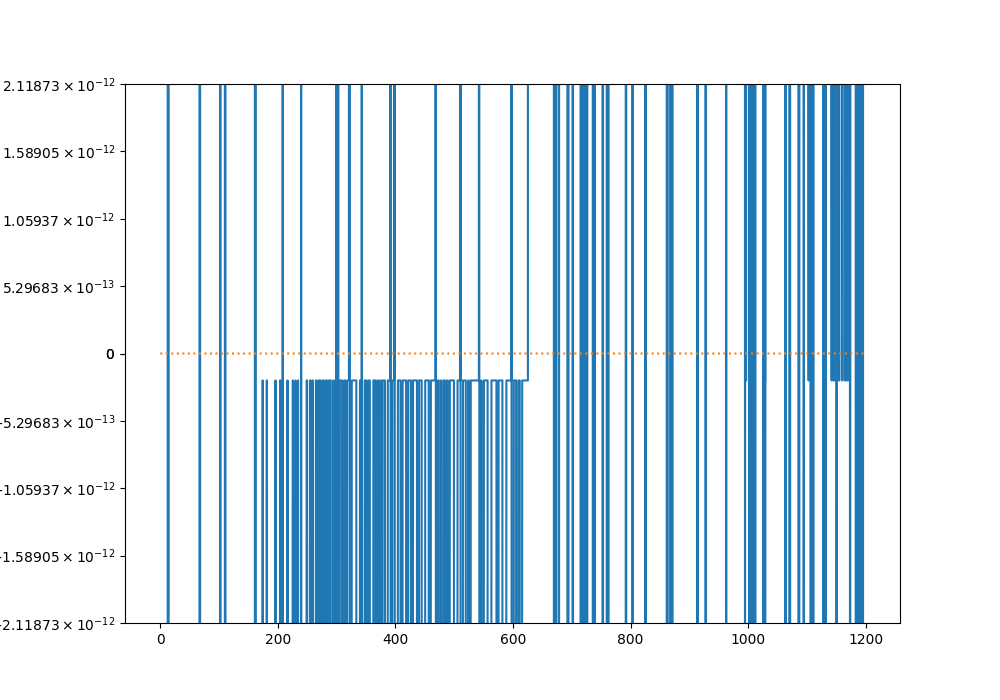

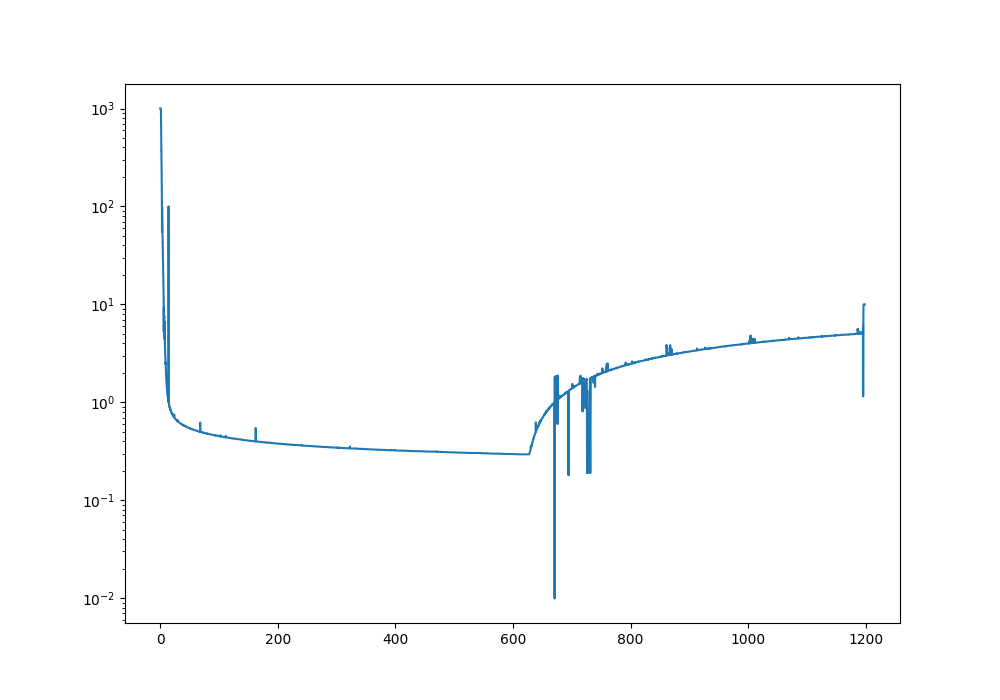

In [431]:
%matplotlib widget
plot_measure('ZERO', {0: 0, 2.9: -1, 5.9: -2, 14.1: 0, 670.691: -2})

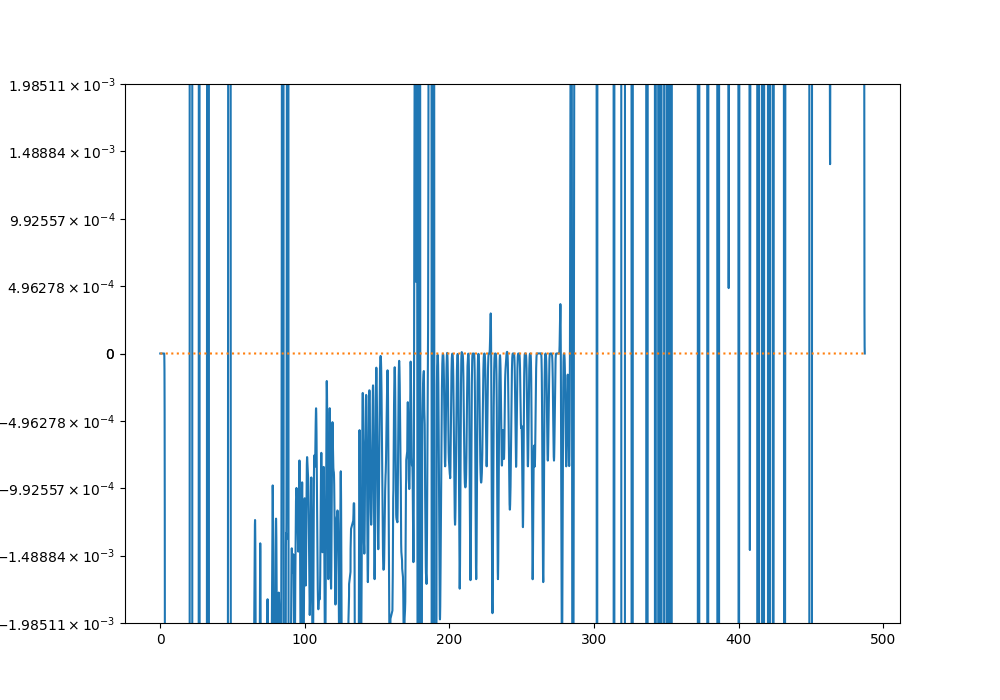

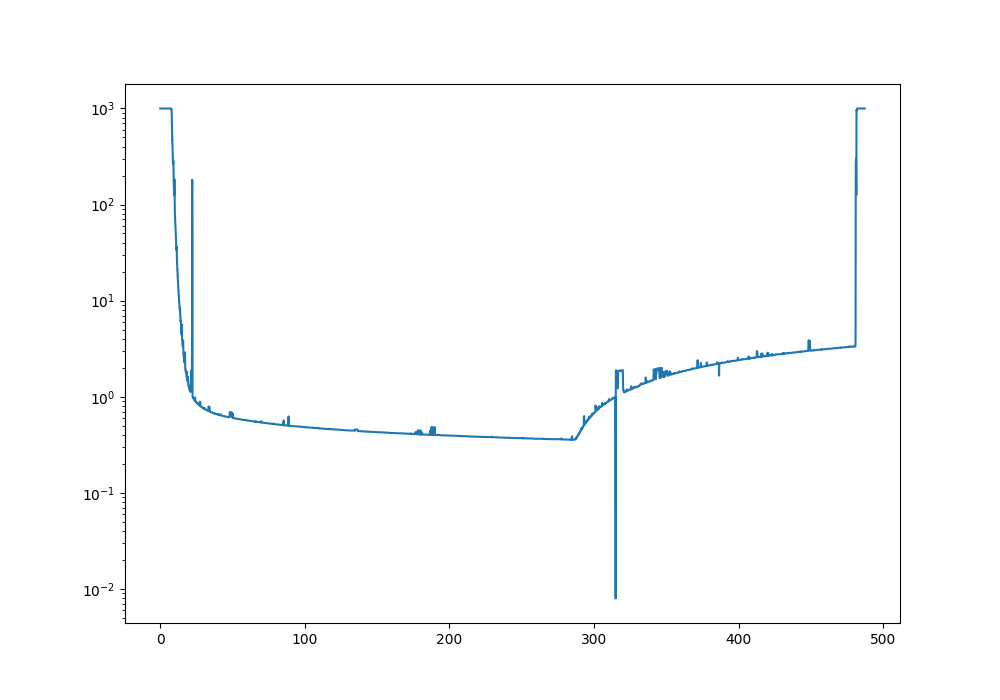

In [432]:
%matplotlib widget
plot_measure('I', {0:0, 9.9: -1, 12.92: -2, 22: 0, 314.8: -2, 481: 0})

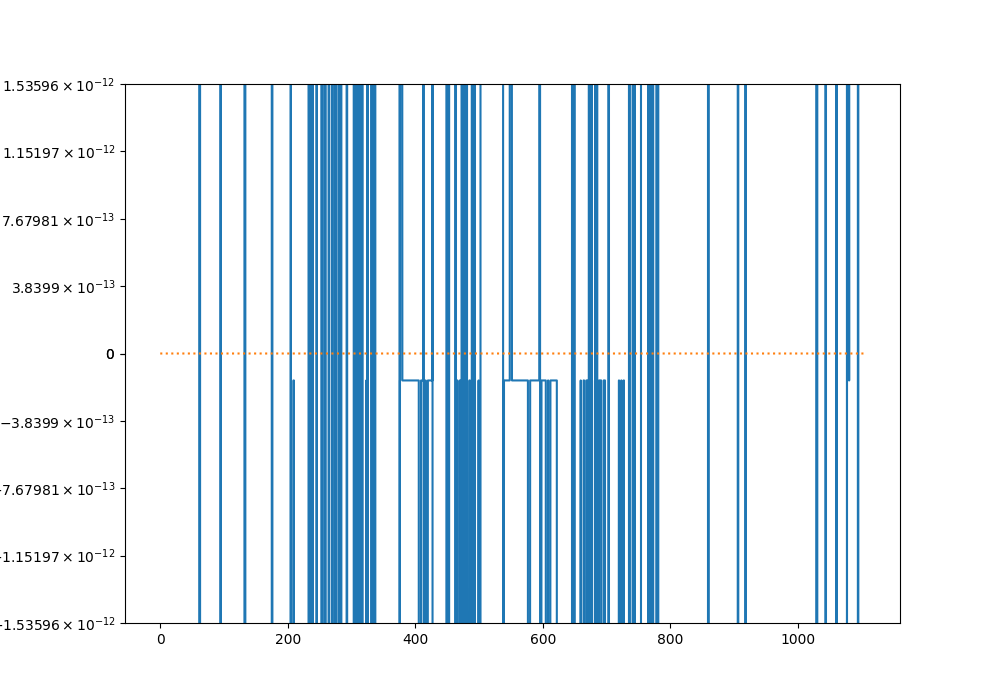

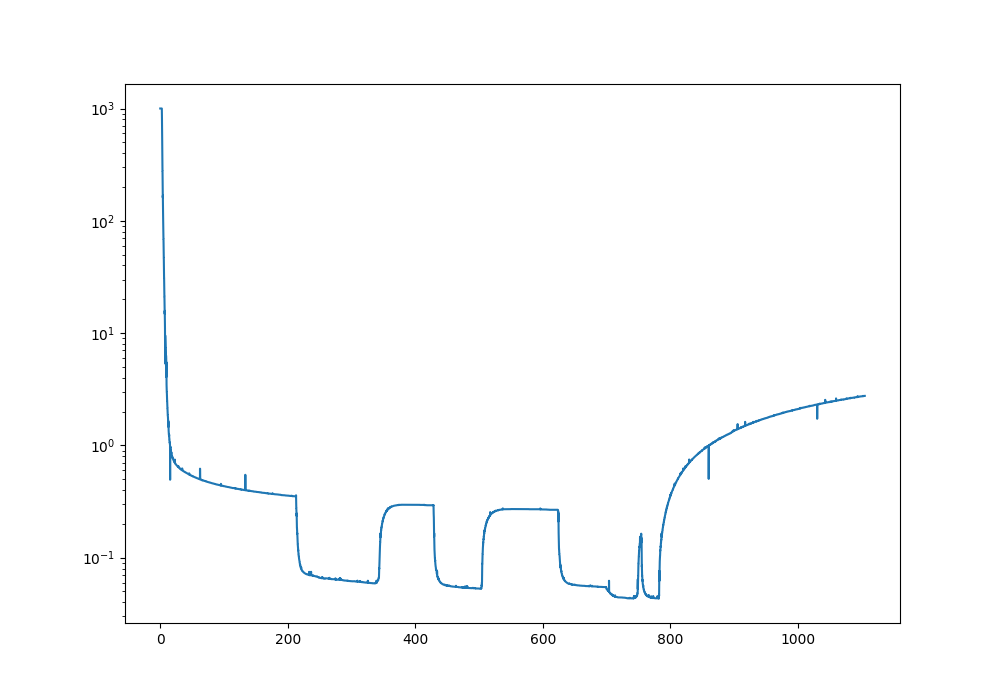

In [433]:
%matplotlib widget
plot_measure('II', {0: 0, 4.63: -1, 7.57: -2, 15.52: 0, 859.9: -2})

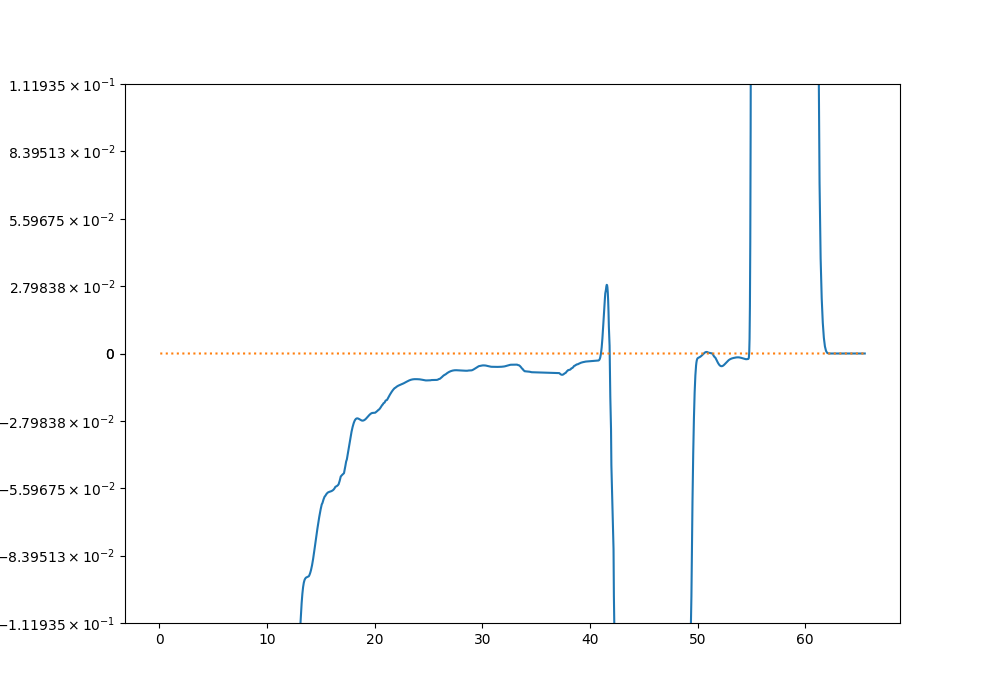

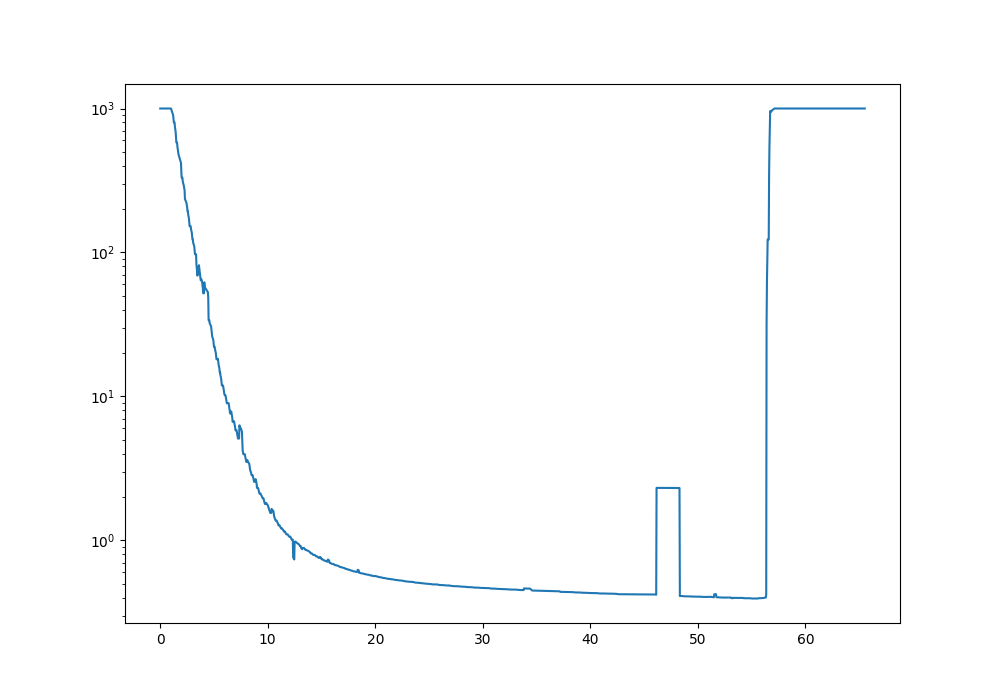

In [434]:
%matplotlib widget
plot_measure('III_1', {0:0, 3.08:-1, 6.1: -2, 12.43: 0})

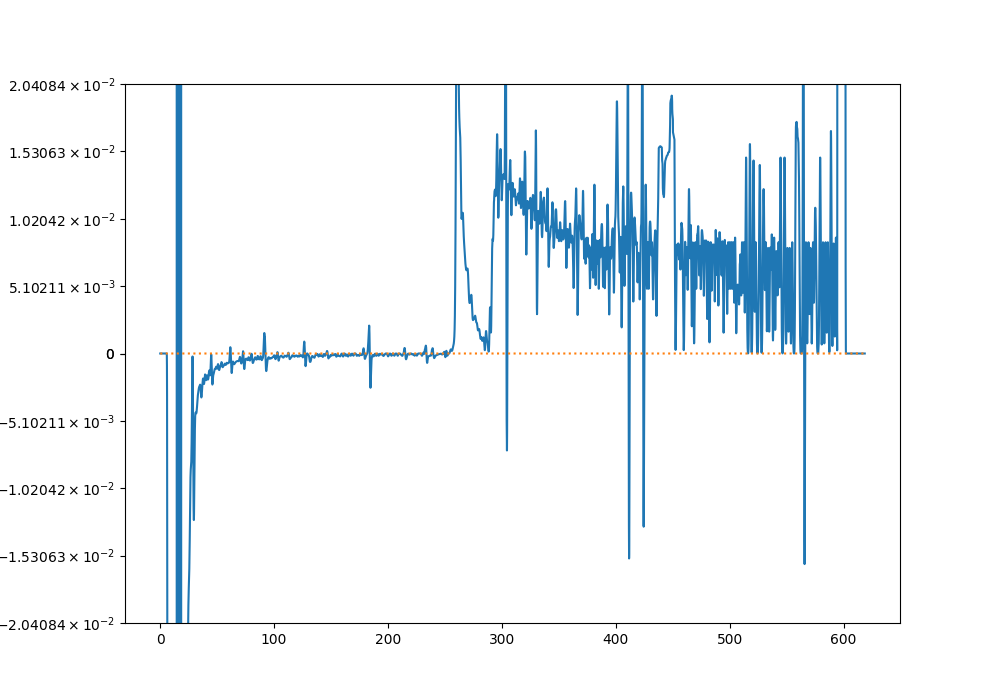

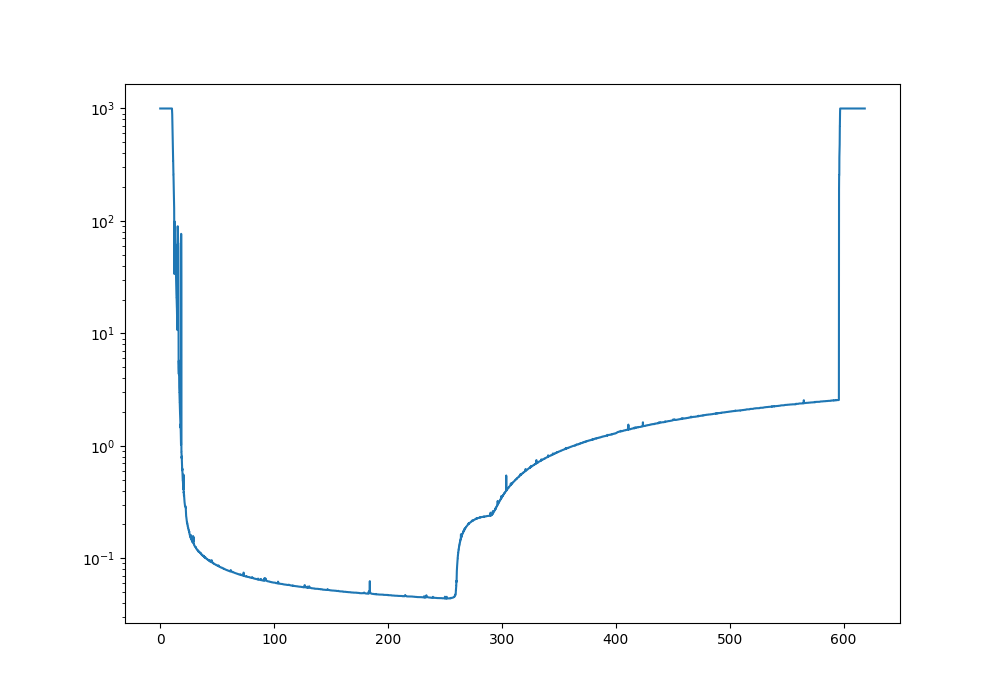

In [435]:
%matplotlib widget
plot_measure('III_2', {0:0, 12.3: -1, 16.0: -2, 18.3: 0, 362.75: -2, 595.9: 0})